In [112]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [113]:
gg = 9.8
rho = 997
beta = 0.25
t = 0
dt = 0.1

In [114]:
class Wave:
    amp = 0.
    k = 0.
    omega = 0.
    phase = 0.
    def __init__(self, a, o, p):
        self.amp = a
        self.omega = o
        self.k = o*o/gg
        self.phase = p
    
    def get(self,x, t):
        return self.amp*math.sin(self.omega*t + self.k*x + self.phase)


In [365]:
class Water:
    waves = []
    def __init__(self, num, random_wave):
        self.waves = []
        if(random_wave==True):
            for i in range(num):
                newWave = Wave(0.1,random.uniform(5,15),random.uniform(1,10))
                self.waves.append(newWave)
        elif(num==0):
            self.waves.append(Wave(0,0,0))
        else:
            self.waves.append(Wave(0.1,0.5,random.uniform(1,10)))
            
    def get(self,x,t):
        waveheight = 0
        for w in self.waves:
            waveheight += w.get(x,t)
        return waveheight

In [258]:
class Particle:
    posx = 0
    posz = 0
    velx = 0
    velz = 0
    accx = 0
    accz = 0
    
    angle = 0
    anglevel = 0
    angleacc = 0

    pl = 3.11
    ph = 0.34
    pw = 0.94
    pv = 0.0878
    mass = pv*100
    cgh = 0.340

    draught = 0

    A11 = 0.3 * rho * pv
    A13 = 0
    A31 = 0
    A53 = 0.1 * rho * pv * pl
    A35 = 0.05* rho * pv * pl
    A33 = 0.3 * rho * pv
    A51 = 0.01* rho * pv * pl
    A55 = 0.07* rho * pv * pl * pl
    B11 = 2.0* rho * pv * math.sqrt(gg/pl)
    B53 = 0.05* rho * pv * pl * math.sqrt(gg/pl)
    B35 = 0.4* rho * pv * pl * math.sqrt(gg/pl)
    B33 = 2.0* rho * pv * math.sqrt(gg/pl)
    B55 = 0.4* rho * pv * pl * pl * math.sqrt(gg/pl)
    C11 = 0
    C53 = 0
    C35 = 0
    C33 = 11014

    azl = []
    pdl = []


    def __init__(self,x,z):
        self.posx = x
        self.posz = z
        self.accx = 0
        self.accz = 0
        self.velx = 0
        self.velz = 0

        self.azl = []
        self.pdl = []

    def calcAcc(self):
        tFx=0
        tFz=0
        tM=0

        average_waveheight = 0
        res = 500
        for i in range(res):
          average_waveheight += ww.get(self.posx-self.pl/2+self.pl/res*i,t)
        average_waveheight = average_waveheight/res

        self.draught = min(max(average_waveheight-(self.posz-self.ph),0), self.ph)
        # print("d=" + "{:.2f}".format(self.draught))
            
        nx = math.cos(self.angle - math.pi/2)
        ny = math.sin(self.angle - math.pi/2)

        az_total = 0
        pd_total = 0

        tFz -= self.mass*gg #Gravity

        if(self.draught>0):
          for w in ww.waves:
            z_t = self.posz - 0.185
            # ax =  w.omega*w.omega*w.amp*math.exp(w.k*self.posz)*math.cos(w.omega*t + w.k*self.posx)
            # ay = -w.omega*w.omega*w.amp*math.exp(w.k*self.posz)*math.sin(w.omega*t + w.k*self.posx)
            # # ay = 0
            # pd =           rho*gg*w.amp*math.exp(w.k*self.posz)*math.sin(w.omega*t + w.k*self.posx)
            # # pd=0

            ax =  w.omega*w.omega*w.amp*math.exp(w.k*z_t)*math.cos(w.omega*t + w.k*self.posx)
            ay = -w.omega*w.omega*w.amp*math.exp(w.k*z_t)*math.sin(w.omega*t + w.k*self.posx)
            # ay = 0
            pd =           rho*gg*w.amp*math.exp(w.k*z_t)*math.sin(w.omega*t + w.k*self.posx)
            # pd=0

            # ax =  w.omega*w.omega*w.amp*math.exp(0)*math.cos(w.omega*t + w.k*self.posx)
            # ay = -w.omega*w.omega*w.amp*math.exp(0)*math.sin(w.omega*t + w.k*self.posx)
            # # ay = 0
            # pd =           rho*gg*w.amp*math.exp(0)*math.sin(w.omega*t + w.k*self.posx)
            # pd=0




            tFx += (-self.pw*self.pl*pd*nx + self.A11*ax + self.A13*ay) *self.draught/self.ph
            tFz += (-self.pw*self.pl*pd*ny + self.A31*ax + self.A33*ay) *self.draught/self.ph
            
            tM += self.A51*ax + self.A53*ay
            # h1 = (tFz - B33*(self.velz + dt/2*self.accz) - C33*(self.posz+dt*self.velz+(0.5-beta)*dt*dt*self.accz))
            # h11 = tFz
            # h12 = - B33*(self.velz + dt/2*self.accz)
            # h13 = - C33*(self.posz+dt*self.velz+(0.5-beta)*dt*dt*self.accz)
            # h2 = ((self.ma+A33) + dt/2*B33 + beta*dt*dt*C33)
            az_total += ay
            pd_total += pd

            z_t = self.posz - 0.185
            heave = (tFz - self.B33*(self.velz + dt/2*self.accz) - self.C33*(z_t+dt*self.velz+(0.5-beta)*dt*dt*self.accz)) / ((self.mass+self.A33) + dt/2*self.B33 + beta*dt*dt*self.C33)
            surge = (tFx - self.B11*(self.velx + dt/2*self.accx)) / ((self.mass+self.A11) + dt/2*self.B11)


            self.accx = surge
            self.accz = heave
        else:
          self.accx = 0
          self.accz = -9.8
        
        
        
        self.azl.append(az_total)
        self.pdl.append(pd_total)
    def update(self,en_thr):
      self.calcAcc()
      self.velx += self.accx*dt
      self.velz += self.accz*dt
      self.posx += self.velx*dt
      self.posz += self.velz*dt
      # print("x=" + "{:.2f}".format(self.posx))
      # print("z=" + "{:.2f}".format(self.posz))
    
   
 

No handles with labels found to put in legend.


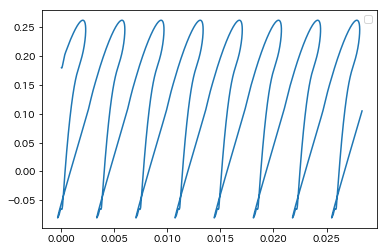

In [368]:
ww = Water(1,random_wave=False)
pp = Particle(0,0.18)
dt = 0.01
t=0
dl = []
xl = []
zl = []
zvl= []
zal =[]
eng = [] 

for i in range(10000):
    pp.update(en_thr=False)
    dl.append(pp.draught)
    xl.append(pp.posx)
    zl.append(pp.posz)
    zvl.append(pp.velz)
    zal.append(pp.accz)
    eng.append(pp.mass*pp.velz**2)
    t+=dt

fig, ax = plt.subplots()
tdata = np.arange(0,10000*dt,dt)
# ax.set_ylim(-0.5,0.5)
# ax.plot(tdata,zl,label="pos")
# ax.plot(tdata,xl,label="pos")
# ax.plot(tdata,zvl,label="vel")
# ax.plot(tdata,zal,label="acc")
# ax.plot(tdata,dl,label="draught")

# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pp.pdl,'--',lw=0.1,label="pressure")
# ax.plot(tdata,pp.azl,label="az")

ax.plot(xl,zl)

ax.legend()

In [267]:
t=0
pp = Particle(0,0.18)
dt = 0.01

0.048095431437208874
-29.863039772815704


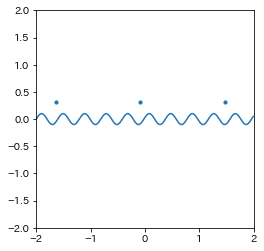

In [354]:
xdata = np.arange(-2,2,0.01)
ydata = np.array([ww.get(x,t) for x in xdata])
fig, ax = plt.subplots()
ax.set_xlim(-2.0,2.0)
ax.set_ylim(-2.0,2.0)
ax.set_aspect('equal', adjustable='box')

ax.plot(xdata,ydata)
ax.scatter([pp.posx-pp.pl/2,pp.posx,pp.posx+pp.pl/2],[pp.posz,pp.posz,pp.posz],s=10)
print(pp.draught/pp.ph)
print(pp.accz)
pp.update(en_thr=False)
t+=dt

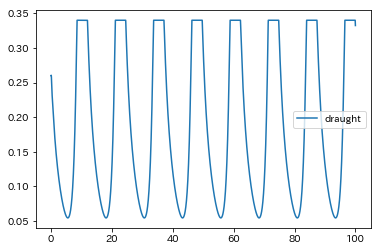

In [369]:
fig, ax = plt.subplots()
tdata = np.arange(0,10000*dt,dt)
# ax.set_ylim(-0.5,0.5)
# ax.plot(tdata,zl,label="pos")
# ax.plot(tdata,xl,label="pos")
# ax.plot(tdata,zvl,label="vel")
# ax.plot(tdata,zal,label="acc")
ax.plot(tdata,dl,label="draught")

# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pp.pdl,'--',lw=0.1,label="pressure")
# ax.plot(tdata,pp.azl,label="az")

# ax.plot(xl,zl)

ax.legend()